In [1]:
# %pip install numpy
# %pip install pandas
# %pip install ipywidgets
# %pip install pylatexenc
# %pip install scikit-learn
# %pip install opencv-python
# %pip install matplotlib
# %pip install seaborn
# %pip install kagglehub
# %pip install monai
# %pip install qiskit==1.4.3
# %pip install qiskit_machine_learning
# %pip install qiskit_algorithms

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import cv2
from PIL import Image
import kagglehub
import joblib
from monai.transforms import ScaleIntensity
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import PegasosQSVC
from qiskit.primitives import Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 42

import warnings
warnings.filterwarnings("ignore")

Download latest version https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [3]:
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
# print("Path to dataset files:", dataset_path)

Data preprocessing

In [4]:
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

valid_exts = ('.jpg', '.jpeg', '.png')

class_map = {
    "glioma": "Glioma",
    "meningioma": "Meningioma",
    "notumor": "No Tumor",
    "pituitary": "Pituitary"
}

def load_dataset(directory):
    images = []
    labels = []

    for folder in sorted(os.listdir(directory)):
        folder_path = os.path.join(directory, folder)
        if not os.path.isdir(folder_path):
            continue
        label_name = class_map.get(folder.lower().strip(), folder.title())
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(valid_exts):
                fpath = os.path.join(folder_path, fname)
                try:
                    img = Image.open(fpath).convert("L").resize((256, 256))
                    arr = np.array(img, dtype=np.float32) / 255.0
                    arr = (arr - 0.5) / 0.5
                    images.append(arr.flatten())
                    labels.append(label_name)
                except Exception as e:
                    print(f"Skipping {fpath}: {e}")

    return np.array(images), np.array(labels)

X_train_all, y_train_all = load_dataset(train_dir)
X_test_all, y_test_all = load_dataset(test_dir)

label_encoder = LabelEncoder()
label_encoder.fit(np.unique(y_train_all.tolist() + y_test_all.tolist()))

y_train = label_encoder.transform(y_train_all)
y_test = label_encoder.transform(y_test_all)

print("Classes:", label_encoder.classes_)
print("Train samples:", len(y_train))
print("Test samples:", len(y_test))

Classes: ['Glioma' 'Meningioma' 'No Tumor' 'Pituitary']
Train samples: 5712
Test samples: 1311


In [5]:
X_train_flat = X_train_all
X_test_flat = X_test_all
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

X_train_balanced = []
y_train_balanced = []

for class_label in np.unique(y_train):
    X_class = X_train_pca[y_train == class_label]
    y_class = y_train[y_train == class_label]
    X_upsampled, y_upsampled = resample(
        X_class, y_class,
        replace=True,
        n_samples=max(np.bincount(y_train)),
        random_state=42
    )
    X_train_balanced.append(X_upsampled)
    y_train_balanced.append(y_upsampled)

X_train_balanced = np.vstack(X_train_balanced)
y_train_balanced = np.hstack(y_train_balanced)

Check data

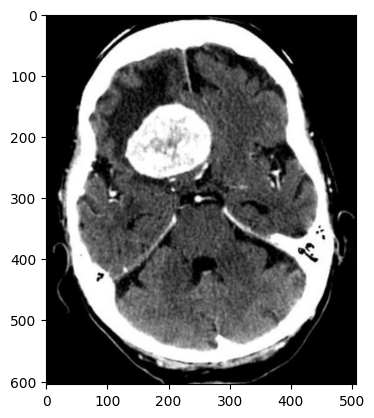

In [6]:
brain_image = cv2.imread(f'{train_dir}/meningioma/Tr-me_0182.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(brain_image, cmap='gray')

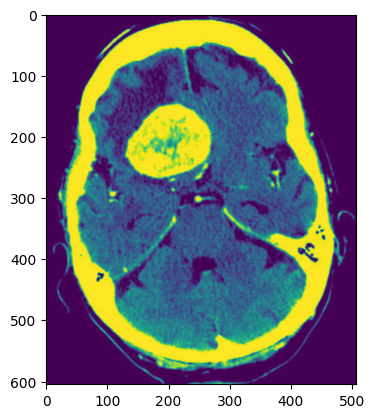

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
brain_image_scaled = transform_img(brain_image)
colored_kid = cm.viridis(brain_image_scaled)
plt.imshow(colored_kid)

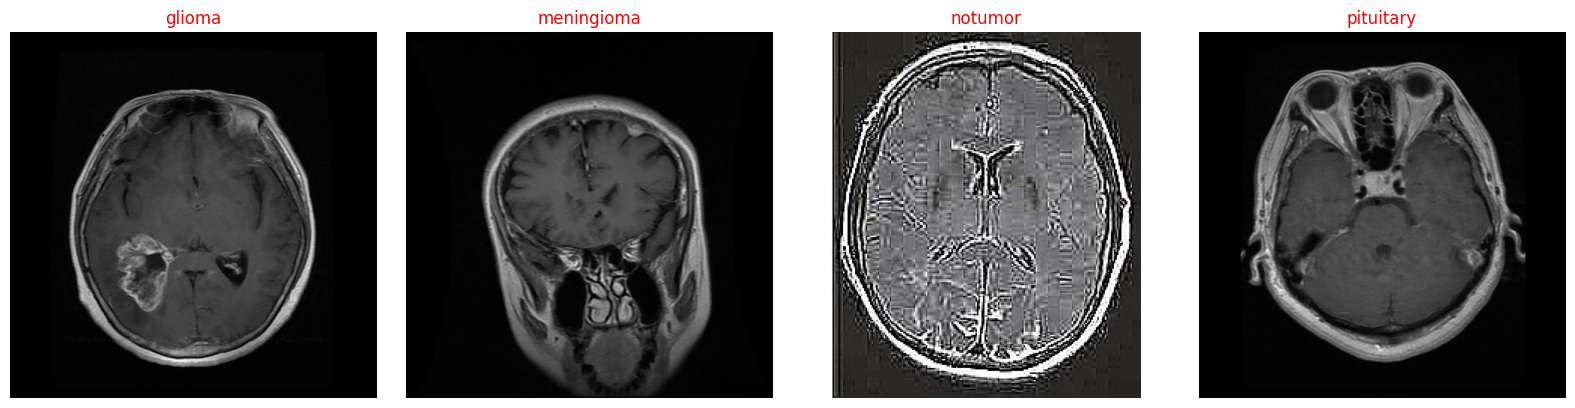

In [8]:
image_dirs = [train_dir, test_dir]

image_index_path_map = {}
for image_dir in image_dirs:
    for class_name in class_map:
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.exists(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(valid_exts):
                image_index_path_map[fname] = os.path.join(class_dir, fname)

sample_images = []
for class_name in class_map:
    for fname, fpath in image_index_path_map.items():
        if class_name.lower() in fpath.lower():
            sample_images.append((fpath, class_name))
            break

plt.figure(figsize=(16, 8))
for i, (img_path, label) in enumerate(sample_images):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=12, color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Class distribution

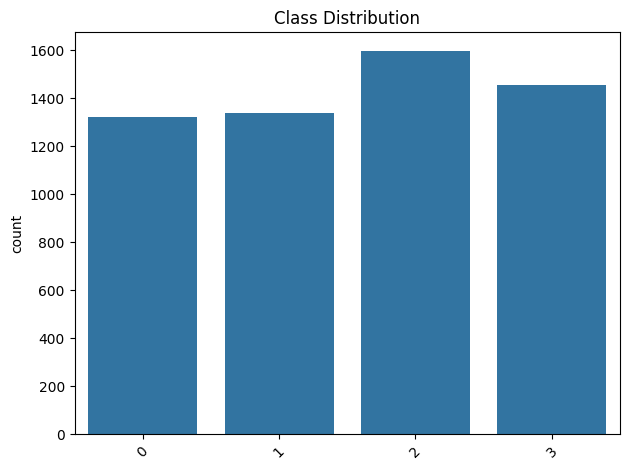

In [9]:
sns.countplot(x=y_train)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.tight_layout()

Convolutional & Pooling Layers

In [10]:
def conv_layer(num_qubits, label, params):
    """
    Create a convolutional layer.
    Applies RX gates to each qubit.
    """
    qc = QuantumCircuit(num_qubits, name=label)
    for i in range(num_qubits):
        qc.rx(params[i], i)
    return qc

def pool_layer(qubits, label):
    """
    Create a pooling layer.
    Applies CX gates between adjacent qubits.
    """
    qc = QuantumCircuit(len(qubits), name=label)
    for i in range(0, len(qubits) - 1, 2):
        qc.cx(qubits[i], qubits[i + 1])
    return qc

Create ansatz

In [11]:
def calculate_total_params(num_qubits, layers=4):
    """
    Calculate the total number of parameters required for the ansatz.
    """
    total_params = num_qubits * layers
    return total_params

In [12]:
def build_ansatz(num_qubits, params):
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")
    layer_params = iter(params)

    for layer in range(1, 5):
        conv_params = [next(layer_params) for _ in range(num_qubits)]
        ansatz.compose(
            conv_layer(num_qubits, f"c{layer}", conv_params),
            range(num_qubits),
            inplace=True
        )
        ansatz.compose(
            pool_layer(range(num_qubits), f"p{layer}"),
            range(num_qubits),
            inplace=True
        )

    return ansatz

num_qubits = 2
total_params = calculate_total_params(num_qubits)
params = [Parameter(f'θ{i}') for i in range(total_params)]

ansatz = build_ansatz(num_qubits, params)


Circuit visualization

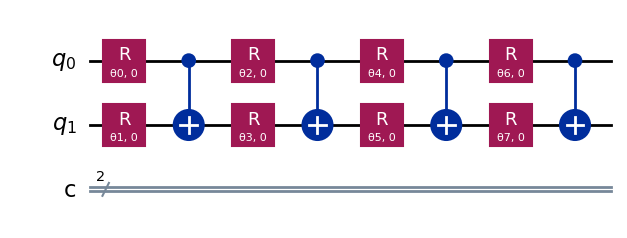

In [13]:
circuit = QuantumCircuit(num_qubits, num_qubits)
circuit.compose(ansatz, range(num_qubits), inplace=True)
circuit = circuit.decompose()

circuit.draw("mpl", style="iqx")

In [14]:
class CustomMulticlassPegasos:
    def __init__(self, quantum_kernel, num_steps=1000, C=10.0):
        self.classifiers = {}
        self.classes = []
        self.kernel = quantum_kernel
        self.num_steps = num_steps
        self.C = C

    def fit(self, X, y):
        self.classes = np.unique(y)
        for class_id in self.classes:
            print(f"Training CustomMulticlassPegasos for class {class_id} ({label_encoder.classes_[class_id]})")
            y_binary = np.where(y == class_id, 1, 0)
            clf = PegasosQSVC(
                quantum_kernel=self.kernel,
                num_steps=self.num_steps,
                C=self.C
            )
            clf.fit(X, y_binary)
            self.classifiers[class_id] = clf

    def predict(self, X):
        decisions = []
        for class_id, clf in self.classifiers.items():
            score = clf.decision_function(X)
            decisions.append(score)
        decisions = np.array(decisions)
        return np.argmax(decisions, axis=0)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return metrics.accuracy_score(y, y_pred)

    def save(self, filepath):
        joblib.dump({
            'classifiers': self.classifiers,
            'classes': self.classes,
            'num_steps': self.num_steps,
            'C': self.C
        }, filepath)

    @classmethod
    def load(cls, filepath, quantum_kernel):
        data = joblib.load(filepath)
        instance = cls(quantum_kernel, num_steps=data['num_steps'], C=data['C'])
        instance.classifiers = data['classifiers']
        instance.classes = data['classes']
        return instance


Quantum Kernel Setup

In [ ]:
sampler = Sampler()

quantum_kernel = FidelityQuantumKernel(feature_map=ansatz)

Fit model

In [16]:
multiclass_pegasos = CustomMulticlassPegasos(
    quantum_kernel=quantum_kernel,
    num_steps=1000,
    C=10.0
)

multiclass_pegasos.fit(X_train_balanced, y_train_balanced)

Training CustomMulticlassPegasos for class 0 (Glioma)
Training CustomMulticlassPegasos for class 1 (Meningioma)
Training CustomMulticlassPegasos for class 2 (No Tumor)
Training CustomMulticlassPegasos for class 3 (Pituitary)


Save model

In [17]:
multiclass_pegasos.save('models/Multiclass_PegasosQSVC_Fidelity_quantm_trainer_brain.model')

#### Evaluation

Subsample 100 test examples, maintaining class balance

In [18]:
subset_split = StratifiedShuffleSplit(n_splits=1, test_size=300, random_state=42)
for _, test_subset_idx in subset_split.split(X_test_pca, y_test):
    X_test_subset = X_test_pca[test_subset_idx]
    y_test_subset = y_test[test_subset_idx]

y_pred = multiclass_pegasos.predict(X_test_subset)

In [19]:
print("Test Accuracy:", metrics.accuracy_score(y_test_subset, y_pred))
print("\nClassification Report:")
print(metrics.classification_report(y_test_subset, y_pred, target_names=label_encoder.classes_))
print("Macro F1 Score:", metrics.f1_score(y_test_subset, y_pred, average='macro'))
print("Weighted F1 Score:", metrics.f1_score(y_test_subset, y_pred, average='weighted'))

Test Accuracy: 0.23333333333333334

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.22      0.28      0.25        69
  Meningioma       0.22      0.51      0.31        70
    No Tumor       0.32      0.12      0.17        93
   Pituitary       0.22      0.06      0.09        68

    accuracy                           0.23       300
   macro avg       0.25      0.24      0.21       300
weighted avg       0.25      0.23      0.20       300

Macro F1 Score: 0.20550443114009348
Weighted F1 Score: 0.20364230976449652


In [20]:
conf_matrix = metrics.confusion_matrix(y_test_subset, y_pred)
print("Confusion Matrix:\n", conf_matrix)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0))
    return (e_x / e_x.sum(axis=0)).T

decision_scores = np.array([
    clf.decision_function(X_test_subset) for clf in multiclass_pegasos.classifiers.values()
])
y_prob = softmax(decision_scores)

y_test_subset_oh = label_binarize(y_test_subset, classes=range(len(label_encoder.classes_)))

roc_auc = metrics.roc_auc_score(y_test_subset_oh, y_prob, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

Confusion Matrix:
 [[19 43  7  0]
 [19 36  9  6]
 [27 47 11  8]
 [20 37  7  4]]
ROC AUC Score: 0.49902550169114823


Plot the confusion matrix

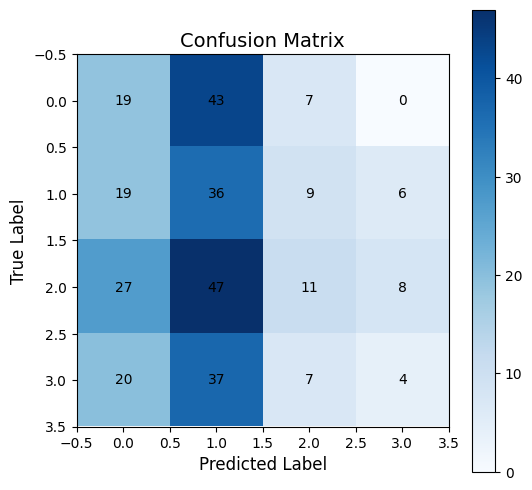

In [21]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

Plot the ROC curve

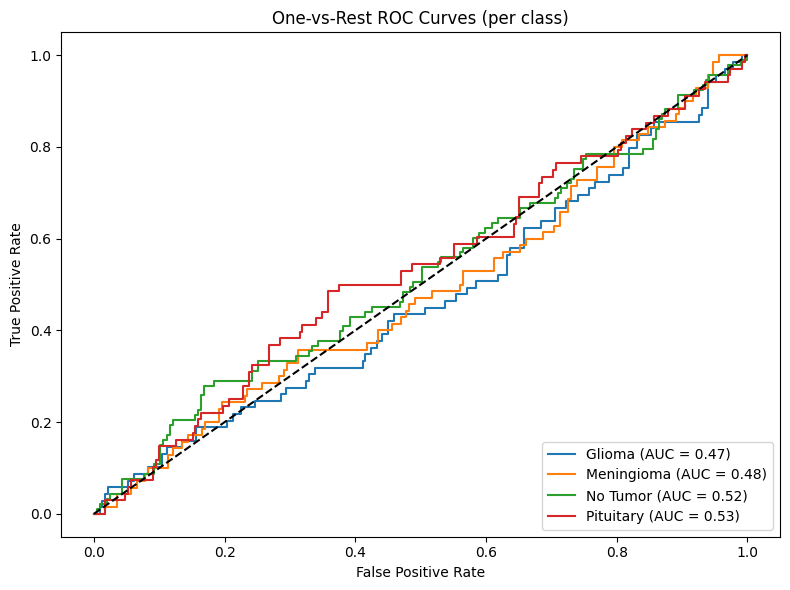

In [22]:
fpr = dict()
tpr = dict()
roc_auc_individual = dict()
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_subset_oh[:, i], y_prob[:, i])
    roc_auc_individual[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc_individual[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (per class)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Predicted probability for Positive Class

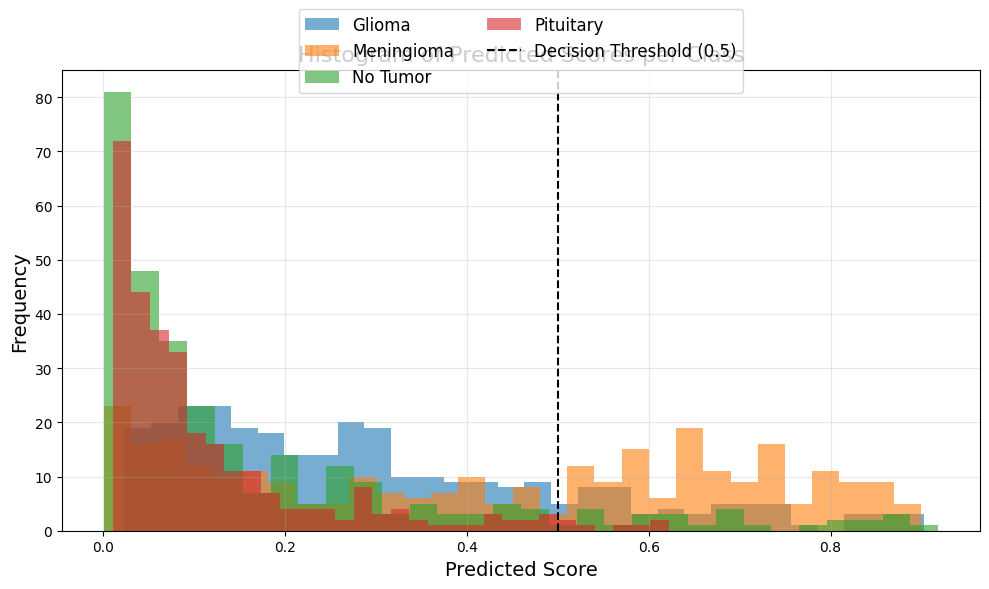

In [23]:
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(label_encoder.classes_):
    plt.hist(
        y_prob[:, i],
        bins=30,
        alpha=0.6,
        label=class_name
    )

plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)
plt.title('Histogram of Predicted Scores per Class', fontsize=16)
plt.xlabel('Predicted Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

PCA of model prediction

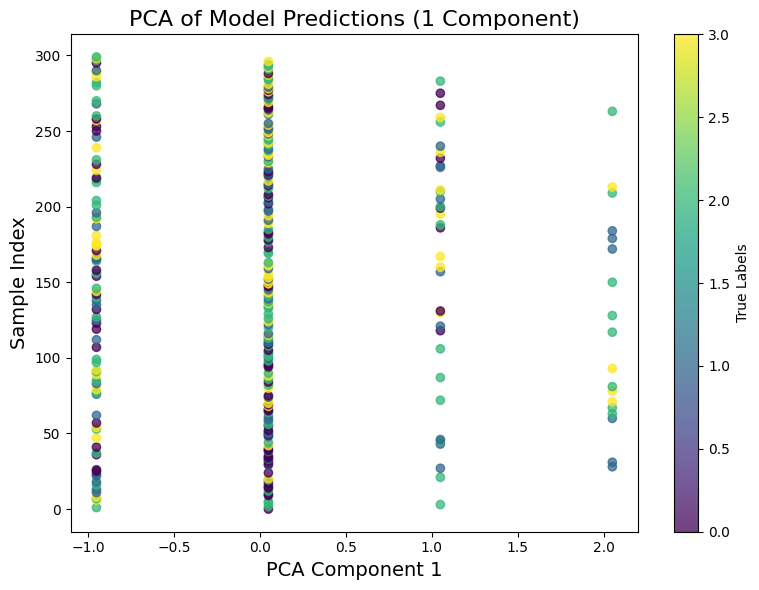

In [24]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca, range(len(features_pca)), c=y_test_subset, cmap='viridis', alpha=0.75)
plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)
plt.tight_layout()
plt.show()

Load model

In [25]:
loaded_model = CustomMulticlassPegasos.load('models/Multiclass_PegasosQSVC_Fidelity_quantm_trainer_brain.model', quantum_kernel=quantum_kernel)

Test loaded model

In [26]:
train_score = loaded_model.score(X_train_balanced[:100], y_train_balanced[:100])
test_score = loaded_model.score(X_test_pca[:100], y_test[:100])

print(f"CustomMulticlassPegasos on the training dataset: {train_score:.2f}")
print(f"CustomMulticlassPegasos on the test dataset: {test_score:.2f}")

CustomMulticlassPegasos on the training dataset: 0.29
CustomMulticlassPegasos on the test dataset: 0.31


In [27]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright